In [1]:
import torch
import torch.nn as nn
import math

# 1. Embedding Layer
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, x):
        return self.embedding(x)

# 2. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        # x: (batch_size, seq_len, embed_dim)
        return x + self.pe[:, :x.size(1)]

# 3. Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    
    def forward(self, x, mask=None):
        return self.transformer_encoder(x, mask=mask)

# 4. Language Model Head
class LanguageModelHead(nn.Module):
    def __init__(self, embed_dim, vocab_size):
        super(LanguageModelHead, self).__init__()
        self.linear = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, x):
        return self.linear(x)

# 5. Full Model
class FullModel(nn.Module):
    def __init__(self, vocab_size=10000, embed_dim=512, num_heads=8, num_layers=6, dim_feedforward=2048, max_len=512, dropout=0.1):
        super(FullModel, self).__init__()
        self.embedding = EmbeddingLayer(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)
        self.transformer = TransformerModel(embed_dim, num_heads, num_layers, dim_feedforward, dropout)
        self.lm_head = LanguageModelHead(embed_dim, vocab_size)
    
    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.lm_head(x)
        return x

In [49]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

29164304

In [2]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random

class DummyDataset(Dataset):
    def __init__(self, vocab_size, seq_len, num_samples=1000):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.num_samples = num_samples
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        input_seq = torch.randint(0, self.vocab_size, (self.seq_len,))
        # Целевая последовательность сдвинута на один шаг вперед
        target_seq = torch.cat([input_seq[1:], torch.tensor([random.randint(0, self.vocab_size - 1)])])
        return input_seq, target_seq

In [3]:
from ogo import TrainableExperimentModel


def transformer_train_step(m: TrainableExperimentModel):
    m.model.train()
    total_loss = 0
    
    for batch_idx, (input_seq, target_seq) in enumerate(m.dataloader_train):
        input_seq, target_seq = input_seq.to(m.device), target_seq.to(m.device)
        
        m.optimizer.zero_grad()
        
        output = m.model(input_seq)

        loss = m.loss(output.view(-1, output.size(-1)), target_seq.view(-1))
        
        loss.backward()
        
        m.optimizer.step()
        
        total_loss += loss.item()

In [4]:
from ogo import TrainableExperimentModel


def transformer_test(m: TrainableExperimentModel):
    m.model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_idx, (input_seq, target_seq) in enumerate(m.dataloader_test):
            input_seq, target_seq = input_seq.to(m.device), target_seq.to(m.device)
            output = m.model(input_seq)
            
            # Разворачиваем выход модели и целевые метки
            output_flat = output.view(-1, output.size(-1))  # [batch_size * seq_len, vocab_size]
            target_flat = target_seq.view(-1)              # [batch_size * seq_len]
            
            loss = m.loss(output_flat, target_flat)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(m.dataloader_test)
    m.history.append({"avg_train_loss": avg_val_loss}) ### TTTTTTTTTTTTTTEEEEEEEEEESTTT LOOOOOOOOSSSSSSSSSSSSSSS !!!

In [5]:
parts = [
    ["embedding"],
    ["transformer.transformer_encoder.layers.0"],
    ["transformer.transformer_encoder.layers.1"],
    ["transformer.transformer_encoder.layers.2"],
    ["transformer.transformer_encoder.layers.3"],
    ["transformer.transformer_encoder.layers.4"],
    ["transformer.transformer_encoder.layers.5"],
    ["lm_head"]
]

In [6]:
from ogo import ExperimentDescription, generate_experiment

vocab_size=10000
seq_len = 128

description = ExperimentDescription(
    model=FullModel,
    loss=lambda: nn.CrossEntropyLoss(ignore_index=-1),
    optimizer=torch.optim.AdamW,
    optimizer_params={"lr": 5e-4},
    dataset_train=DummyDataset(vocab_size=vocab_size, seq_len=seq_len, num_samples=8000),
    dataset_test=DummyDataset(vocab_size=vocab_size, seq_len=seq_len, num_samples=2000),
    batch_size=32,
    epochs=10,
    model_copies_epochs=1,
    model_copies_submodules=parts,
    model_reference_device="cuda",
    model_general_device="cuda",
    model_copies_devices=["cuda","cuda","cuda", "cuda","cuda","cuda", "cuda","cuda"],
    model_train_step=transformer_train_step,
    model_test=transformer_test
)

experiment = generate_experiment(description)

In [7]:
# raise Exception()

In [8]:
from ogo import experiment_train_reference

experiment_train_reference(experiment)
# experiment.model_reference.history

100%|██████████| 10/10 [08:07<00:00, 48.78s/it]


In [9]:
experiment.model_reference.history

[{'avg_train_loss': 9.235063295515756},
 {'avg_train_loss': 9.223137053232344},
 {'avg_train_loss': 9.217898717002264},
 {'avg_train_loss': 9.214985771784706},
 {'avg_train_loss': 9.213593543521942},
 {'avg_train_loss': 9.21299934387207},
 {'avg_train_loss': 9.212073492625404},
 {'avg_train_loss': 9.211418681674534},
 {'avg_train_loss': 9.211340419829838},
 {'avg_train_loss': 9.21104497758169}]

In [10]:
from ogo import experiment_train_general

experiment_train_general(experiment)
# experiment.model_general.history

100%|██████████| 10/10 [48:53<00:00, 293.35s/it]


In [11]:
experiment.model_general.history

[{'avg_train_loss': 9.29114533984472},
 {'avg_train_loss': 9.27398283519442},
 {'avg_train_loss': 9.241239532591804},
 {'avg_train_loss': 9.218987025911845},
 {'avg_train_loss': 9.212508670867436},
 {'avg_train_loss': 9.212058173285591},
 {'avg_train_loss': 9.211387513175843},
 {'avg_train_loss': 9.211142751905653},
 {'avg_train_loss': 9.211300683399987},
 {'avg_train_loss': 9.211107208615257}]

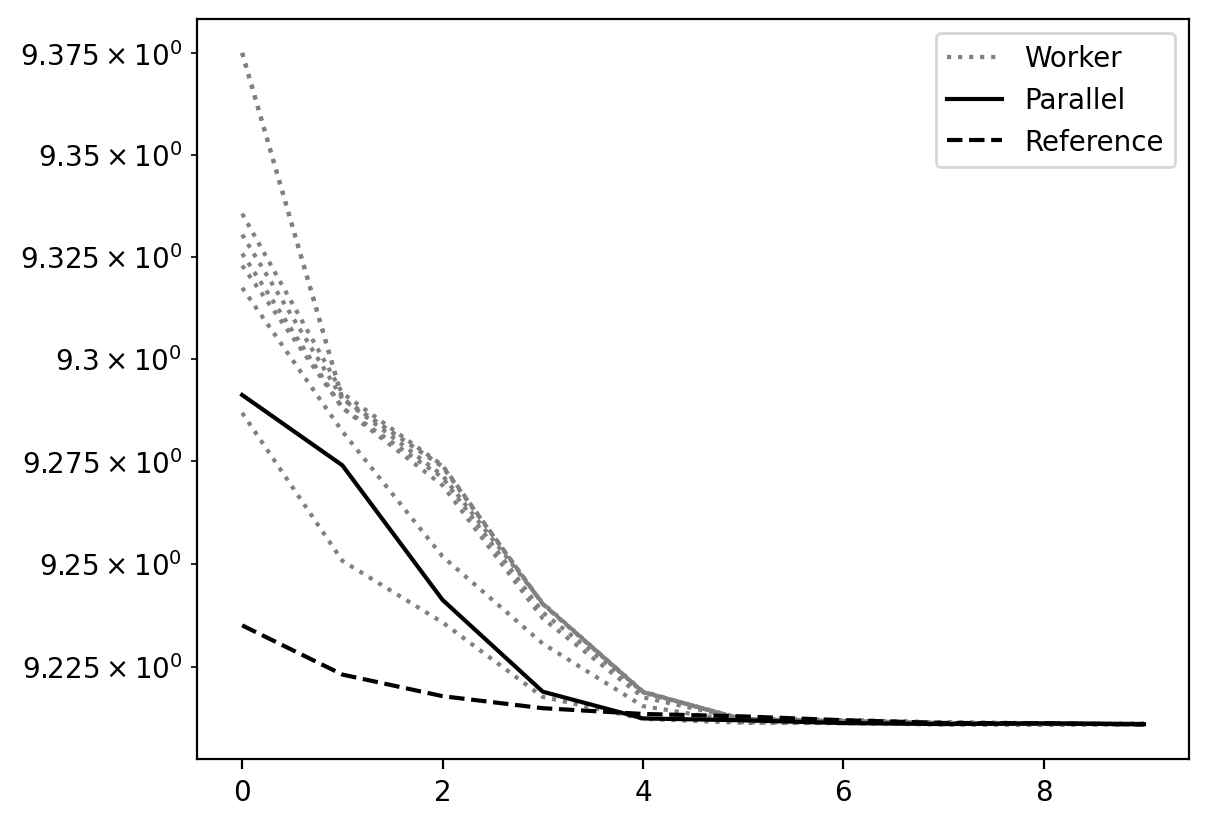

In [37]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

start = 0
stop = experiment.epochs
x = range(start, stop)
copy_step = 1
general_step = 1
reference_step = 1

plt.plot(x, [x["avg_train_loss"] for x in experiment.model_copies[0].history[start:stop:copy_step]], linestyle='dotted', color='gray', label='Worker')

for m in experiment.model_copies[:-1]:
    plt.plot(x, [x["avg_train_loss"] for x in m.history[start:stop:copy_step]], linestyle='dotted', color='gray')

plt.plot(x, [x["avg_train_loss"] for x in experiment.model_general.history[start:stop:general_step]], label='Parallel', color='black', linestyle='solid')
plt.plot(x, [x["avg_train_loss"] for x in experiment.model_reference.history[start:stop:reference_step]], label='Reference', color='black', linestyle='dashed')

plt.legend()
plt.yscale('log')
plt.show()

In [13]:
experiment.model_reference.history[-1]

{'avg_train_loss': 9.21104497758169}

In [14]:
experiment.model_general.history[-1]

{'avg_train_loss': 9.211107208615257}